## **Try** 2

In [ ]:
# ------------------------------------------------------------
# STEP 1️⃣: Import required libraries
# ------------------------------------------------------------
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import networkx as nx

print("✅ Libraries imported successfully.\n")


✅ Libraries imported successfully.



In [ ]:
# ------------------------------------------------------------
# STEP 2️⃣: Load and preprocess review data (with Drive path)
# ------------------------------------------------------------
import pandas as pd
import json
from sklearn.preprocessing import LabelEncoder

# ✅ Replace this with your actual file path
reviews_file = '/content/drive/MyDrive/All_Beauty_5.json'

reviews_data = []

with open(reviews_file, 'r') as f:
    for line_number, line in enumerate(f, 1):
        line = line.strip()
        if not line:
            continue
        try:
            reviews_data.append(json.loads(line))
        except json.JSONDecodeError:
            print(f"⚠️ Skipping malformed review line {line_number}")
            continue

# Convert to DataFrame
reviews_df = pd.DataFrame(reviews_data)
print(f"📦 Step 2 Done: Reviews loaded — {len(reviews_df)} rows")

# Keep only necessary columns and drop missing values
reviews_df = reviews_df[['reviewerID', 'asin', 'overall', 'unixReviewTime']].dropna()

# Convert timestamp to datetime
reviews_df['unixReviewTime'] = pd.to_datetime(reviews_df['unixReviewTime'], unit='s')

# Encode users and items
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

reviews_df['user_id'] = user_encoder.fit_transform(reviews_df['reviewerID'])
reviews_df['item_id'] = item_encoder.fit_transform(reviews_df['asin'])

# Display summary
print(f"👤 Unique users: {reviews_df['user_id'].nunique()}")
print(f"🎁 Unique items: {reviews_df['item_id'].nunique()}")
print("✅ Step 2 complete: Review data preprocessed.\n")


📦 Step 2 Done: Reviews loaded — 5269 rows
👤 Unique users: 991
🎁 Unique items: 85
✅ Step 2 complete: Review data preprocessed.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ------------------------------------------------------------
# STEP 3️⃣ (UPDATED): Load and preprocess metadata safely
# ------------------------------------------------------------

metadata_path = '/content/drive/MyDrive/meta_All_Beauty.json'  # update if needed

metadata_data = []
with open(metadata_path, 'r') as f:
    for line in f:
        metadata_data.append(json.loads(line))

metadata_df = pd.DataFrame(metadata_data)

print("📋 Columns available in metadata:", metadata_df.columns.tolist())

# Ensure all required columns exist
for col in ['asin', 'categories', 'also_bought', 'also_viewed', 'item_id']:
    if col not in metadata_df.columns:
        metadata_df[col] = None  # add missing column

# Fill missing values properly
metadata_df['categories'] = metadata_df['categories'].apply(lambda x: x if isinstance(x, list) else [])
metadata_df['also_bought'] = metadata_df['also_bought'].apply(lambda x: x if isinstance(x, list) else [])
metadata_df['also_viewed'] = metadata_df['also_viewed'].apply(lambda x: x if isinstance(x, list) else [])

print(f"\n📦 Metadata loaded: {len(metadata_df)} items")
print(f"📊 Columns now ensured: {list(metadata_df.columns)}")
print("✅ Step 3 complete: Metadata preprocessed safely.\n")


📋 Columns available in metadata: ['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2', 'brand', 'feature', 'rank', 'also_view', 'details', 'main_cat', 'similar_item', 'date', 'price', 'asin', 'imageURL', 'imageURLHighRes']

📦 Metadata loaded: 32892 items
📊 Columns now ensured: ['category', 'tech1', 'description', 'fit', 'title', 'also_buy', 'tech2', 'brand', 'feature', 'rank', 'also_view', 'details', 'main_cat', 'similar_item', 'date', 'price', 'asin', 'imageURL', 'imageURLHighRes', 'categories', 'also_bought', 'also_viewed', 'item_id']
✅ Step 3 complete: Metadata preprocessed safely.



In [ ]:
# ------------------------------------------------------------
# STEP 4️⃣: Merge review and metadata dataframes
# ------------------------------------------------------------

# Merge on 'asin'
merged_df = pd.merge(reviews_df, metadata_df, on='asin', how='inner')

print(f"🔗 Merged data shape: {merged_df.shape}")
print(f"👤 Unique users after merge: {merged_df['user_id'].nunique()}")
print(f"🎁 Unique items after merge: {merged_df['asin'].nunique()}")
print("✅ Step 4 complete: Review and metadata merged successfully.\n")


🔗 Merged data shape: (5767, 28)
👤 Unique users after merge: 991
🎁 Unique items after merge: 85
✅ Step 4 complete: Review and metadata merged successfully.



In [ ]:
# ------------------------------------------------------------
# STEP 5️⃣: Build the product graph using NetworkX
# ------------------------------------------------------------

G = nx.Graph()

# Add nodes (products)
for _, row in metadata_df.iterrows():
    G.add_node(row['asin'], title=row.get('title', ''), category=row.get('main_cat', ''))

# Add edges based on also_view, also_buy, similar_item relationships
for _, row in metadata_df.iterrows():
    asin = row['asin']
    related_items = set()

    # Collect all related items (if they exist)
    if isinstance(row.get('also_view'), list):
        related_items.update(row['also_view'])
    if isinstance(row.get('also_buy'), list):
        related_items.update(row['also_buy'])
    if isinstance(row.get('similar_item'), list):
        related_items.update(row['similar_item'])

    # Add edges between this product and related products
    for related_asin in related_items:
        if related_asin in metadata_df['asin'].values:
            G.add_edge(asin, related_asin)


In [ ]:
  print(f"🕸️ Product graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
print("✅ Step 5 complete: Graph successfully created.\n")

🕸️ Product graph built with 32488 nodes and 2947 edges.
✅ Step 5 complete: Graph successfully created.



In [ ]:
# ------------------------------------------------------------
# STEP 6️⃣ (UPDATED): Graph statistics and save progress safely
# ------------------------------------------------------------
import pickle

# Compute graph stats
graph_stats = {
    'num_nodes': G.number_of_nodes(),
    'num_edges': G.number_of_edges(),
    'avg_degree': sum(dict(G.degree()).values()) / G.number_of_nodes(),
    'density': nx.density(G)
}

print("📈 Graph Statistics:")
for k, v in graph_stats.items():
    print(f"   {k}: {v:.4f}" if isinstance(v, float) else f"   {k}: {v}")

# Save graph and stats manually using pickle
with open('/content/drive/MyDrive/product_graph.pkl', 'wb') as f:
    pickle.dump(G, f)

with open('/content/drive/MyDrive/graph_stats.pkl', 'wb') as f:
    pickle.dump(graph_stats, f)

print("\n💾 Graph and stats saved successfully to Google Drive.")
print("✅ Step 6 complete: Progress saved safely.\n")


📈 Graph Statistics:
   num_nodes: 32488
   num_edges: 2947
   avg_degree: 0.1814
   density: 0.0000

💾 Graph and stats saved successfully to Google Drive.
✅ Step 6 complete: Progress saved safely.



In [ ]:
# ------------------------------------------------------------
# STEP 7.1️⃣ : Build user-item interaction sequences
# ------------------------------------------------------------
from collections import defaultdict

# Sort reviews by user and time
reviews_df.sort_values(by=['user_id', 'unixReviewTime'], inplace=True)

# Build sequences
user_sequences = defaultdict(list)
for row in reviews_df.itertuples():
    user_sequences[row.user_id].append(row.item_id)

# Example check
first_user = list(user_sequences.items())[0]
print(f"👤 Example user ID: {first_user[0]}")
print(f"🛍️ Sequence of interacted items: {first_user[1]}")
print(f"📏 Sequence length: {len(first_user[1])}")

print(f"\n✅ Step 7.1 complete: User sequences created ({len(user_sequences)} users).")


👤 Example user ID: 0
🛍️ Sequence of interacted items: [5, 6, 13, 29, 29]
📏 Sequence length: 5

✅ Step 7.1 complete: User sequences created (991 users).


In [ ]:
# ------------------------------------------------------------
# STEP 7.2️⃣ : Split user sequences into train and test sets
# ------------------------------------------------------------
train_sequences = {}
test_sequences = {}

for user, seq in user_sequences.items():
    if len(seq) < 2:
        continue  # skip very short histories
    train_sequences[user] = seq[:-1]
    test_sequences[user] = seq[-1]

print(f"🧩 Train sequences prepared: {len(train_sequences)} users")
print(f"🧪 Test samples prepared: {len(test_sequences)} users")

# Example preview
example_user = list(train_sequences.items())[0]
print(f"\n👤 Example train sequence for user {example_user[0]}: {example_user[1]}")
print(f"🎯 Test item for same user: {test_sequences[example_user[0]]}")

print("\n✅ Step 7.2 complete: Train/Test split created successfully.")


🧩 Train sequences prepared: 991 users
🧪 Test samples prepared: 991 users

👤 Example train sequence for user 0: [5, 6, 13, 29]
🎯 Test item for same user: 29

✅ Step 7.2 complete: Train/Test split created successfully.


In [ ]:
# ------------------------------------------------------------
# STEP 7.3️⃣ : Prepare model input (padded sequences)
# ------------------------------------------------------------
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Convert training sequences to list of lists
train_list = list(train_sequences.values())
test_list = list(test_sequences.values())

# Pad training sequences to same length
max_seq_len = max(len(seq) for seq in train_list)
train_padded = pad_sequences(train_list, maxlen=max_seq_len, padding='pre')

# Convert to numpy arrays
train_padded = np.array(train_padded)

print(f"🧮 Padded training shape: {train_padded.shape}")
print(f"📏 Max sequence length: {max_seq_len}")

# Example padded sequence
print(f"Example padded sequence for user 0: {train_padded[0]}")

print("\n✅ Step 7.3 complete: Sequences formatted for model input.")


🧮 Padded training shape: (991, 11)
📏 Max sequence length: 11
Example padded sequence for user 0: [ 0  0  0  0  0  0  0  5  6 13 29]

✅ Step 7.3 complete: Sequences formatted for model input.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import networkx as nx

# Load the graph
with open('/content/drive/MyDrive/product_graph.pkl', 'rb') as f:
    G = pickle.load(f)

# ✅ Modern way to check graph info
print(f"Graph loaded successfully ✅")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.4f}")

Graph loaded successfully ✅
Number of nodes: 32488
Number of edges: 2947
Average degree: 0.1814


In [ ]:
import pickle

with open('/content/drive/MyDrive/graph_stats.pkl', 'rb') as f:
    graph_stats = pickle.load(f)

"""with open('/content/drive/MyDrive/user_sequences.pkl', 'rb') as f:
    user_sequences = pickle.load(f)

with open('/content/drive/MyDrive/padded_sequences.pkl', 'rb') as f:
    padded_sequences = pickle.load(f)"""


"with open('/content/drive/MyDrive/user_sequences.pkl', 'rb') as f:\n    user_sequences = pickle.load(f)\n\nwith open('/content/drive/MyDrive/padded_sequences.pkl', 'rb') as f:\n    padded_sequences = pickle.load(f)"

In [ ]:
# ---------------------------
# HYBRID MODEL: FULL SCRIPT
# ---------------------------
# Requirements:
# pip install torch gensim networkx tqdm scikit-learn
# (If running in Colab: !pip install torch gensim networkx tqdm scikit-learn)
# ---------------------------

import numpy as np
import random
from collections import defaultdict
from tqdm import tqdm
import pickle
import os

import networkx as nx
from gensim.models import Word2Vec

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ---------------------------
# A. Prepare item id namespace & inputs
# ---------------------------
print("A. Preparing inputs and checking variables...")

# The code below assumes items are integer-coded (item_id) in your sequences.
# If your graph G uses ASIN strings as nodes, we'll map between them and item ids.

# Detect whether G nodes are item_id integers or asin strings
sample_node = next(iter(G.nodes()))
nodes_are_int = isinstance(sample_node, (int, np.integer))
print(f"  - Graph nodes are ints? {nodes_are_int}")

# Build mappings between node (graph) and item_id index used in sequences:
# If G nodes are ASIN strings but item_encoder uses ASINs -> map will be straightforward.
# We will build two maps: node_to_idx (graph node -> numerical index in [0, n_items-1])
# and idx_to_node.
graph_nodes = list(G.nodes())
node_to_graphidx = {n: i for i, n in enumerate(graph_nodes)}
graphidx_to_node = {i: n for n, i in node_to_graphidx.items()}

# Also ensure we have a consistent item index mapping used by the sequences.
num_items = len(item_encoder.classes_)  # number items used by encoder
print(f"  - num_items from item_encoder: {num_items}")

# We need to know whether sequences use item_id values that correspond to graph node indices.
# If your sequences use item_id = item_encoder.transform(asins), and G nodes are ASIN strings,
# we will later map via the ASIN -> item_id mapping.
# Build asin <-> item_id maps
asin_to_itemid = {a: i for i, a in enumerate(item_encoder.classes_)}
itemid_to_asin = {i: a for a, i in asin_to_itemid.items()}

print("A done.\n")

# ---------------------------
# B. Create Node2Vec-like random walks on G (to get graph embeddings)
# ---------------------------
print("B. Creating random walks on the product graph (for Node2Vec-style embeddings)...")

def generate_random_walks(G, num_walks=10, walk_length=40):
    walks = []
    nodes = list(G.nodes())
    for _ in range(num_walks):
        random.shuffle(nodes)
        for node in nodes:
            walk = [str(node)]
            current = node
            for _ in range(walk_length - 1):
                neighbors = list(G.neighbors(current))
                if not neighbors:
                    break
                current = random.choice(neighbors)
                walk.append(str(current))
            walks.append(walk)
    return walks

# parameters — these are safe defaults; you can increase if you want richer embeddings
num_walks = 10
walk_length = 20

walks = generate_random_walks(G, num_walks=num_walks, walk_length=walk_length)
print(f"  - Generated {len(walks)} walks (sample walk length {len(walks[0]) if walks else 0}).")

# Train Word2Vec on these walks to get item vectors
embedding_size = 64
w2v_model = Word2Vec(walks, vector_size=embedding_size, window=5, min_count=0, sg=1, workers=2, epochs=5)
print("  - Word2Vec trained on random walks.")

# Build graph embedding matrix aligned to item_id space.
# For each item_id (0..num_items-1) we want a vector. If item (asin) not in w2v vocab, use random.
graph_embed_matrix = np.zeros((num_items + 1, embedding_size), dtype=np.float32)  # +1 for pad idx 0

for itemid in range(num_items):
    asin = itemid_to_asin[itemid]
    # node string stored in Word2Vec is str(node) as we used str() above
    if str(asin) in w2v_model.wv:
        vec = w2v_model.wv[str(asin)]
    elif str(itemid) in w2v_model.wv:
        # sometimes nodes were integers and Word2Vec vocab contains itemid strings
        vec = w2v_model.wv[str(itemid)]
    else:
        vec = np.random.normal(scale=0.01, size=(embedding_size,))
    graph_embed_matrix[itemid + 1] = vec  # +1 to reserve 0 for padding

print("B done: Graph embeddings prepared (aligned to item indices). \n")

# ---------------------------
# C. Prepare sequential dataset tensors
# ---------------------------
print("C. Preparing PyTorch dataset from padded sequences...")

# Use the train_padded from preprocessing (numpy array shape (n_users, seq_len))
# and test_list (the ground-truth next items in same ordering).
try:
    X = train_padded      # numpy array created previously (shape: n_users, seq_len)
except NameError:
    raise RuntimeError("train_padded not found. Make sure Step 7.3 produced train_padded variable.")

# Build y from test_sequences (we used list(test_sequences.values()) previously)
y = np.array(list(test_sequences.values()), dtype=np.int64)

assert X.shape[0] == y.shape[0], "Number of rows in X must match number of test targets."

# convert to PyTorch tensors later in DataLoader
print(f"  - X shape: {X.shape}, y shape: {y.shape}")
print("C done.\n")

# ---------------------------
# D. PyTorch Dataset + DataLoader
# ---------------------------
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64
dataset = SeqDataset(X, y)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print("D done: DataLoader created.\n")

# ---------------------------
# E. Hybrid Model (Graph embeddings + GRU sequence encoder)
# ---------------------------
print("E. Building hybrid model (PyTorch)...")

class HybridSeqGraph(nn.Module):
    def __init__(self, num_items, graph_embed_matrix, seq_embed_dim=64, gru_hidden=128, dropout=0.2):
        super().__init__()
        # trainable item embedding for sequential part (index 0 reserved for padding)
        self.seq_embedding = nn.Embedding(num_items + 1, seq_embed_dim, padding_idx=0)
        # initialize sequential embedding for non-zero indices randomly (default)

        # graph embedding: we use pretrained matrix but also allow fine-tuning
        self.graph_embedding = nn.Embedding(num_items + 1, graph_embed_matrix.shape[1], padding_idx=0)
        self.graph_embedding.weight.data.copy_(torch.tensor(graph_embed_matrix))
        # optionally freeze graph embeddings by uncommenting:
        # self.graph_embedding.weight.requires_grad = False

        self.gru = nn.GRU(seq_embed_dim, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(dropout)

        # fusion: concatenate GRU hidden state and item-graph-mean vector then predict
        fusion_dim = gru_hidden + graph_embed_matrix.shape[1]
        self.fc1 = nn.Linear(fusion_dim, 256)
        self.fc2 = nn.Linear(256, num_items + 1)  # +1 for padding index; we will ignore 0 in metrics

    def forward(self, seqs):
        # seqs: (batch, seq_len)
        seq_emb = self.seq_embedding(seqs)                # (batch, seq_len, seq_embed_dim)
        _, h_n = self.gru(seq_emb)                        # h_n: (1, batch, gru_hidden)
        h_n = h_n.squeeze(0)                              # (batch, gru_hidden)
        h_n = self.dropout(h_n)

        # global graph summary vector: mean of all item graph embeddings (learnable)
        # Option: you can compute per-user graph-aware vector (like average of items in sequence)
        # Here we compute avg of graph embeddings of items present in the input sequence:
        # mask padding zero
        mask = (seqs != 0).unsqueeze(-1)                  # (batch, seq_len, 1)
        g_embs = self.graph_embedding(seqs)               # (batch, seq_len, graph_dim)
        summed = (g_embs * mask).sum(dim=1)               # (batch, graph_dim)
        counts = mask.sum(dim=1).clamp(min=1).float()     # avoid div by zero
        avg_graph = summed / counts                       # (batch, graph_dim)

        # fusion
        fusion = torch.cat([h_n, avg_graph], dim=1)       # (batch, fusion_dim)
        x = torch.relu(self.fc1(fusion))
        x = self.dropout(x)
        logits = self.fc2(x)                              # (batch, num_items+1)
        return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSeqGraph(num_items=num_items, graph_embed_matrix=graph_embed_matrix, seq_embed_dim=64, gru_hidden=128).to(device)
print(model)
print("E done: Model instantiated.\n")

# ---------------------------
# F. Training loop
# ---------------------------
print("F. Training the hybrid model...")

epochs = 8
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # ignore padding label 0 if present

for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0.0
    for batch_x, batch_y in loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        logits = model(batch_x)                  # (batch, num_items+1)
        # we will ignore index 0 as candidate (padding), but model outputs include it
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_x.size(0)
    epoch_loss /= len(dataset)
    print(f"  Epoch {epoch}/{epochs}  avg_loss: {epoch_loss:.4f}")

print("F done: Training finished.\n")

# ---------------------------
# G. Evaluation: accuracy and Recall@K
# ---------------------------
print("G. Evaluating model: Accuracy + Recall@K")

model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch_x, batch_y in DataLoader(dataset, batch_size=256, shuffle=False):
        batch_x = batch_x.to(device)
        logits = model(batch_x)                  # (batch, num_items+1)
        probs = torch.softmax(logits, dim=1)
        top1 = torch.argmax(probs, dim=1).cpu().numpy()
        all_preds.extend(top1.tolist())
        all_targets.extend(batch_y.numpy().tolist())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

accuracy = (all_preds == all_targets).mean()
print(f"  Accuracy (top-1): {accuracy:.4f}")

# Recall@K function
def recall_at_k(model, dataset, K=10):
    model.eval()
    hits = 0
    total = 0
    with torch.no_grad():
        loader_eval = DataLoader(dataset, batch_size=256, shuffle=False)
        for bx, by in loader_eval:
            bx = bx.to(device)
            logits = model(bx)
            topk = torch.topk(logits, k=min(K, logits.shape[1]), dim=1).indices.cpu().numpy()
            # check if true label in topk
            for i in range(topk.shape[0]):
                total += 1
                if by[i].item() in topk[i]:
                    hits += 1
    return hits / total

for K in [5, 10]:
    r_at_k = recall_at_k(model, dataset, K=K)
    print(f"  Recall@{K}: {r_at_k:.4f}")

print("G done: Evaluation complete.\n")

# ---------------------------
# H. Save model & artifacts
# ---------------------------
print("H. Saving model and artifacts...")
os.makedirs('/content/drive/MyDrive/hybrid_recommender', exist_ok=True)
torch.save(model.state_dict(), '/content/drive/MyDrive/hybrid_recommender/hybrid_model.pt')
with open('/content/drive/MyDrive/hybrid_recommender/graph_embed_matrix.npy', 'wb') as f:
    np.save(f, graph_embed_matrix)
print("H done: Saved model and graph embeddings to Google Drive.\n")

print("ALL DONE: Hybrid sequential + graph model training & evaluation finished.")


A. Preparing inputs and checking variables...
  - Graph nodes are ints? False
  - num_items from item_encoder: 85
A done.

B. Creating random walks on the product graph (for Node2Vec-style embeddings)...
  - Generated 324880 walks (sample walk length 1).
  - Word2Vec trained on random walks.
B done: Graph embeddings prepared (aligned to item indices). 

C. Preparing PyTorch dataset from padded sequences...
  - X shape: (991, 11), y shape: (991,)
C done.

D done: DataLoader created.

E. Building hybrid model (PyTorch)...
HybridSeqGraph(
  (seq_embedding): Embedding(86, 64, padding_idx=0)
  (graph_embedding): Embedding(86, 64, padding_idx=0)
  (gru): GRU(64, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=86, bias=True)
)
E done: Model instantiated.

F. Training the hybrid model...
  Epoch 1/8  avg_loss: 3.1273
  Epoch 2/8  avg_loss: 1.3701
  Epoch 3/8  avg_loss: 

In [ ]:
pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 84.6 MB/s eta 0:00:00


In [ ]:
import torch, pickle, numpy as np, os

# model: PyTorch model instance (trained)
save_dir = '/content/drive/MyDrive/hybrid_recommender'
os.makedirs(save_dir, exist_ok=True)
torch.save(model.state_dict(), f'{save_dir}/hybrid_model.pt')

# save graph embedding matrix (if you trained it)
np.save(f'{save_dir}/graph_embed_matrix.npy', graph_embed_matrix)

# save encoders and any mapping dictionaries
with open(f'{save_dir}/item_encoder.pkl', 'wb') as f:
    pickle.dump(item_encoder, f)
with open(f'{save_dir}/user_sequences.pkl', 'wb') as f:
    pickle.dump(dict(user_sequences), f)
print("Saved model + artifacts.")


Saved model + artifacts.


In [ ]:
import torch, pickle, numpy as np

save_dir = '/content/drive/MyDrive/hybrid_recommender'
with open(f'{save_dir}/item_encoder.pkl','rb') as f:
    item_encoder = pickle.load(f)
graph_embed_matrix = np.load(f'{save_dir}/graph_embed_matrix.npy')
# rebuild model architecture (same class definition as training)
model = HybridSeqGraph(num_items=len(item_encoder.classes_), graph_embed_matrix=graph_embed_matrix, seq_embed_dim=64, gru_hidden=128)
model.load_state_dict(torch.load(f'{save_dir}/hybrid_model.pt', map_location='cpu'))
model.eval()


HybridSeqGraph(
  (seq_embedding): Embedding(86, 64, padding_idx=0)
  (graph_embedding): Embedding(86, 64, padding_idx=0)
  (gru): GRU(64, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=86, bias=True)
)

In [ ]:
import torch
def recommend_for_sequence(model, seq_padded, k=10, device='cpu'):
    model.to(device)
    seq = torch.tensor(seq_padded, dtype=torch.long).unsqueeze(0).to(device)  # shape (1, seq_len)
    with torch.no_grad():
        logits = model(seq)                       # (1, num_items+1)
        probs = torch.softmax(logits, dim=1).cpu().numpy().flatten()
    # ignore padding index 0
    probs[0] = -1.0
    topk_idx = probs.argsort()[-k:][::-1]
    return topk_idx  # these are item_id indices

# convert item_id back to asin
def ids_to_asins(indices, item_encoder):
    # item_encoder.classes_ gives ASIN ordering that maps index -> asin if you used same transform
    # If you had +1 padding offset use indices-1 mapping where needed
    asins = []
    for idx in indices:
        # if you used +1 offset in embedding, convert properly
        # In our training we used item indices aligned with encoder (1..N) with 0 pad.
        asin = item_encoder.classes_[idx-1] if idx>0 else None
        asins.append(asin)
    return asins


In [ ]:
recommend_for_sequence(model, X[15], k=10)

array([40, 62, 56, 33, 63,  6,  7, 52, 13, 71])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HybridSeqGraph(nn.Module):
    def __init__(self, num_items, graph_embed_matrix, seq_embed_dim=64, gru_hidden=128):
        super(HybridSeqGraph, self).__init__()
        # Graph embedding matching training version
        self.graph_embedding = nn.Embedding.from_pretrained(
            torch.FloatTensor(graph_embed_matrix), freeze=False
        )

        # Sequence embedding matching training version
        self.seq_embedding = nn.Embedding(num_items, seq_embed_dim)

        # GRU layer for sequence modeling
        self.gru = nn.GRU(seq_embed_dim, gru_hidden, batch_first=True)

        # Two fully connected layers (matching fc1 and fc2)
        self.fc1 = nn.Linear(gru_hidden + seq_embed_dim, 128)  # adjust to match your original settings
        self.fc2 = nn.Linear(128, num_items)

    def forward(self, seq):
        # sequence-based part
        seq_emb = self.seq_embedding(seq)           # (batch_size, seq_len, embed_dim)
        _, h_n = self.gru(seq_emb)                  # h_n: (1, batch_size, hidden_dim)
        h_n = h_n.squeeze(0)                        # (batch_size, hidden_dim)

        # graph-based part: get embedding of last item in sequence
        last_item = seq[:, -1]
        graph_emb = self.graph_embedding(last_item) # (batch_size, graph_embed_dim)

        # combine graph + sequence embeddings
        combined = torch.cat([h_n, graph_emb], dim=1)

        # pass to FC layers
        x = F.relu(self.fc1(combined))
        logits = self.fc2(x)
        return logits


In [ ]:
# ====== Evaluation cell (paste & run) ======
import os, pickle, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import ndcg_score

save_dir = '/content/drive/MyDrive/hybrid_recommender'
assert os.path.exists(save_dir), f"{save_dir} does not exist. Update save_dir if needed."

# ---- 1) load artifacts ----
with open(os.path.join(save_dir, 'item_encoder.pkl'), 'rb') as f:
    item_encoder = pickle.load(f)

with open(os.path.join(save_dir, 'user_sequences.pkl'), 'rb') as f:
    user_sequences = pickle.load(f)

graph_embed_matrix = np.load(os.path.join(save_dir, 'graph_embed_matrix.npy'))
state_dict = torch.load(os.path.join(save_dir, 'hybrid_model.pt'), map_location='cpu')

num_items = len(item_encoder.classes_)  # matches training
print(f"Loaded artifacts: num_items={num_items}, graph_embed_matrix.shape={graph_embed_matrix.shape}")

# ---- 2) Recreate exact model class used in training ----
class HybridSeqGraph(nn.Module):
    def __init__(self, num_items, graph_embed_matrix, seq_embed_dim=64, gru_hidden=128, dropout=0.2):
        super().__init__()
        # +1 for padding index 0 (matches training code)
        self.seq_embedding = nn.Embedding(num_items + 1, seq_embed_dim, padding_idx=0)
        self.graph_embedding = nn.Embedding(num_items + 1, graph_embed_matrix.shape[1], padding_idx=0)
        self.graph_embedding.weight.data.copy_(torch.tensor(graph_embed_matrix))
        self.gru = nn.GRU(seq_embed_dim, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        fusion_dim = gru_hidden + graph_embed_matrix.shape[1]
        self.fc1 = nn.Linear(fusion_dim, 256)
        self.fc2 = nn.Linear(256, num_items + 1)  # matches training output size

    def forward(self, seqs):
        seq_emb = self.seq_embedding(seqs)
        _, h_n = self.gru(seq_emb)
        h_n = h_n.squeeze(0)
        h_n = self.dropout(h_n)

        mask = (seqs != 0).unsqueeze(-1)
        g_embs = self.graph_embedding(seqs)
        summed = (g_embs * mask).sum(dim=1)
        counts = mask.sum(dim=1).clamp(min=1).float()
        avg_graph = summed / counts

        fusion = torch.cat([h_n, avg_graph], dim=1)
        x = torch.relu(self.fc1(fusion))
        x = self.dropout(x)
        logits = self.fc2(x)
        return logits

# instantiate and load weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSeqGraph(num_items=num_items, graph_embed_matrix=graph_embed_matrix, seq_embed_dim=64, gru_hidden=128).to(device)
model.load_state_dict(state_dict)   # load saved weights
model.eval()
print("Model reloaded and set to eval mode.")

# ---- 3) Rebuild X_test and y_test from saved user_sequences (same splitting logic) ----
train_sequences = {}
test_sequences = {}
for user, seq in user_sequences.items():
    if len(seq) < 2:
        continue
    train_sequences[user] = seq[:-1]
    test_sequences[user] = seq[-1]

train_list = list(train_sequences.values())
test_list  = list(test_sequences.values())

max_seq_len = max(len(s) for s in train_list)
X = pad_sequences(train_list, maxlen=max_seq_len, padding='pre')   # numpy array
y = np.array(test_list, dtype=np.int64)

print(f"Rebuilt dataset: X.shape={X.shape}, y.shape={y.shape}, max_seq_len={max_seq_len}")

# ---- 4) DataLoader ----
class EvalDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

eval_dataset = EvalDataset(X, y)
eval_loader = DataLoader(eval_dataset, batch_size=256, shuffle=False)

# ---- 5) Evaluation metrics functions ----
def recall_precision_at_k_from_logits(logits, targets, K):
    # logits: (n, C), targets: (n,)
    order = np.argsort(-logits, axis=1)[:, :K]
    hits = 0
    tp = 0
    for i in range(len(targets)):
        tgt = int(targets[i])
        if tgt in order[i]:
            hits += 1
            tp += 1
    recall = hits / len(targets)
    precision = tp / (K * len(targets))
    return recall, precision

def mrr_from_logits(logits, targets):
    order = np.argsort(-logits, axis=1)
    rr = []
    for i, tgt in enumerate(targets):
        ranks = np.where(order[i] == tgt)[0]
        if len(ranks) == 0:
            rr.append(0.0)
        else:
            rr.append(1.0 / (ranks[0] + 1))
    return np.mean(rr)

def ndcg_at_k_from_logits(logits, targets, K):
    # use sklearn.ndcg_score: needs (n_samples, n_labels) arrays for relevances & scores
    ndcgs = []
    for i in range(len(targets)):
        scores = logits[i]
        true_rel = np.zeros_like(scores)
        true_rel[int(targets[i])] = 1
        ndcg = ndcg_score([true_rel], [scores], k=K)
        ndcgs.append(ndcg)
    return np.mean(ndcgs)

# ---- 6) Run evaluation over all eval_loader, collect logits and targets ----
all_logits = []
all_targets = []

with torch.no_grad():
    for bx, by in eval_loader:
        bx = bx.to(device)
        logits = model(bx)                 # (batch, num_items+1)
        logits = logits.cpu().numpy()
        all_logits.append(logits)
        all_targets.append(by.numpy())

all_logits = np.vstack(all_logits)   # shape (N, C)
all_targets = np.concatenate(all_targets)

# optionally ignore padding index 0 by setting its score to -inf
all_logits[:, 0] = -1e9

# ---- 7) Compute metrics ----
accuracy_top1 = np.mean(np.argmax(all_logits, axis=1) == all_targets)
mrr = mrr_from_logits(all_logits, all_targets)
ndcg_10 = ndcg_at_k_from_logits(all_logits, all_targets, K=10)
recall5, prec5 = recall_precision_at_k_from_logits(all_logits, all_targets, K=5)
recall10, prec10 = recall_precision_at_k_from_logits(all_logits, all_targets, K=10)

print("\n=== Evaluation results ===")
print(f"Accuracy (top-1): {accuracy_top1:.4f}")
print(f"MRR:              {mrr:.4f}")
print(f"NDCG@10:          {ndcg_10:.4f}")
print(f"Recall@5:         {recall5:.4f}")
print(f"Precision@5:      {prec5:.4f}")
print(f"Recall@10:        {recall10:.4f}")
print(f"Precision@10:     {prec10:.4f}")
print("==========================\n")

# ---- 8) Save per-user results ----
import pandas as pd
pred_ranks = np.argsort(-all_logits, axis=1)  # full ranking
topk5 = pred_ranks[:, :5].tolist()
topk10 = pred_ranks[:, :10].tolist()

df_eval = pd.DataFrame({
    'true_item': all_targets,
    'pred_top1': np.argmax(all_logits, axis=1),
    'top5': topk5,
    'top10': topk10
})
df_eval.to_csv(os.path.join(save_dir, 'evaluation_results.csv'), index=False)
print(f"Per-user evaluation saved to {os.path.join(save_dir, 'evaluation_results.csv')}")
# ====== end cell ======


Loaded artifacts: num_items=85, graph_embed_matrix.shape=(86, 64)
Model reloaded and set to eval mode.
Rebuilt dataset: X.shape=(991, 11), y.shape=(991,), max_seq_len=11

=== Evaluation results ===
Accuracy (top-1): 0.8527
MRR:              0.8910
NDCG@10:          0.9103
Recall@5:         0.9395
Precision@5:      0.1879
Recall@10:        0.9778
Precision@10:     0.0978

Per-user evaluation saved to /content/drive/MyDrive/hybrid_recommender/evaluation_results.csv


Final Try

In [ ]:
pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 86.8 MB/s eta 0:00:00


In [ ]:
import os
import json
import pickle
import random
from collections import defaultdict
from itertools import combinations
from tqdm import tqdm
import numpy as np
import pandas as pd
import networkx as nx
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# =====================================================================
# CONFIGURATION
# =====================================================================

class Config:
    # Paths (UPDATE THESE)
    DRIVE_PATH = '/content/drive/MyDrive'
    REVIEWS_FILE = f'{DRIVE_PATH}/All_Beauty_5.json'
    METADATA_FILE = f'{DRIVE_PATH}/meta_All_Beauty.json'
    CHECKPOINT_DIR = f'{DRIVE_PATH}/hybrid_recommender_checkpoints'

    # Model hyperparameters
    SEQ_EMBED_DIM = 64
    GRAPH_EMBED_DIM = 64
    GRU_HIDDEN = 128
    MAX_SEQ_LEN = 20
    DROPOUT = 0.2
    FREEZE_GRAPH = True

    # Training parameters
    BATCH_SIZE = 64
    EPOCHS = 30
    LEARNING_RATE = 1e-3

    # Graph parameters
    NUM_WALKS = 10
    WALK_LENGTH = 20

    # Device
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    @classmethod
    def create_dirs(cls):
        os.makedirs(cls.CHECKPOINT_DIR, exist_ok=True)
Config.create_dirs()
print(f"✅ Using device: {Config.DEVICE}")
print(f"✅ Checkpoints will be saved to: {Config.CHECKPOINT_DIR}")

✅ Using device: cuda
✅ Checkpoints will be saved to: /content/drive/MyDrive/hybrid_recommender_checkpoints


In [ ]:
# =====================================================================
# STAGE 1: DATA LOADING & PREPROCESSING
# =====================================================================

def load_reviews(file_path):
    """Load and preprocess review data"""
    print("\n" + "="*70)
    print("STAGE 1: LOADING REVIEWS")
    print("="*70)

    reviews_data = []
    with open(file_path, 'r') as f:
        for line_number, line in enumerate(tqdm(f, desc="Loading reviews"), 1):
            line = line.strip()
            if not line:
                continue
            try:
                reviews_data.append(json.loads(line))
            except json.JSONDecodeError:
                continue

    df = pd.DataFrame(reviews_data)
    print(f"✅ Loaded {len(df)} reviews")

    # Keep essential columns
    df = df[['reviewerID', 'asin', 'overall', 'unixReviewTime']].dropna()
    df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')

    # Encode users and items (offset item_id by 1 to avoid padding conflict)
    user_encoder = LabelEncoder()
    item_encoder = LabelEncoder()
    df['user_id'] = user_encoder.fit_transform(df['reviewerID'])
    df['item_id'] = item_encoder.fit_transform(df['asin']) + 1  # 1 to N

    print(f"👤 Unique users: {df['user_id'].nunique()}")
    print(f"🎁 Unique items: {df['item_id'].nunique()}")

    # Save checkpoint
    checkpoint = {
        'reviews_df': df,
        'user_encoder': user_encoder,
        'item_encoder': item_encoder
    }
    with open(f'{Config.CHECKPOINT_DIR}/01_reviews.pkl', 'wb') as f:
        pickle.dump(checkpoint, f)
    print("💾 Saved checkpoint: 01_reviews.pkl")

    return df, user_encoder, item_encoder
def load_metadata(file_path, review_asins):
    """Load and preprocess metadata, filtered to review items"""
    print("\n" + "="*70)
    print("STAGE 2: LOADING METADATA")
    print("="*70)

    metadata_data = []
    with open(file_path, 'r') as f:
        for line in tqdm(f, desc="Loading metadata"):
            metadata_data.append(json.loads(line))

    df = pd.DataFrame(metadata_data)
    print(f"✅ Loaded metadata for {len(df)} items (full)")

    # Filter to relevant items
    df = df[df['asin'].isin(review_asins)].copy()
    print(f"✅ Filtered to {len(df)} relevant items")

    # Ensure columns exist
    for col in ['asin', 'categories', 'also_bought', 'also_viewed']:
        if col not in df.columns:
            df[col] = None

    # Clean list columns
    df['categories'] = df['categories'].apply(lambda x: x if isinstance(x, list) else [])
    df['also_bought'] = df['also_bought'].apply(lambda x: x if isinstance(x, list) else [])
    df['also_viewed'] = df['also_viewed'].apply(lambda x: x if isinstance(x, list) else [])

    # Save checkpoint
    with open(f'{Config.CHECKPOINT_DIR}/02_metadata.pkl', 'wb') as f:
        pickle.dump(df, f)
    print("💾 Saved checkpoint: 02_metadata.pkl")

    return df

In [ ]:
# =====================================================================
# STAGE 2: GRAPH CONSTRUCTION
# =====================================================================

def build_product_graph(metadata_df, reviews_df):
    """Build product interaction graph using NetworkX"""
    print("\n" + "="*70)
    print("STAGE 3: BUILDING PRODUCT GRAPH")
    print("="*70)

    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(metadata_df['asin'])

    # Add edges from relationships
    edge_count = 0
    for _, row in tqdm(metadata_df.iterrows(), total=len(metadata_df), desc="Adding relation edges"):
        asin = row['asin']
        related_items = set()

        if row.get('also_viewed'):
            related_items.update(row['also_viewed'])
        if row.get('also_bought'):
            related_items.update(row['also_bought'])

        for related_asin in related_items:
            if related_asin in metadata_df['asin'].values:
                G.add_edge(asin, related_asin)
                edge_count += 1

    # Add co-purchase edges (item-item via shared users)
    user_items = defaultdict(set)
    for _, row in tqdm(reviews_df.iterrows(), total=len(reviews_df), desc="Building co-purchase"):
        user_items[row['reviewerID']].add(row['asin'])

    for items_set in tqdm(user_items.values(), desc="Adding co-purchase edges"):
        if len(items_set) > 1:
            items_list = list(items_set)
            for item1, item2 in combinations(items_list, 2):
                G.add_edge(item1, item2)
                edge_count += 1

    print(f"🕸️ Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    print(f"📊 Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    print(f"🔗 Density: {nx.density(G):.6f}")

    # Save checkpoint
    with open(f'{Config.CHECKPOINT_DIR}/03_graph.pkl', 'wb') as f:
        pickle.dump(G, f)
    print("💾 Saved checkpoint: 03_graph.pkl")

    return G

In [ ]:
# =====================================================================
# STAGE 3: GRAPH EMBEDDINGS (Node2Vec)
# =====================================================================

def generate_random_walks(G, num_walks=10, walk_length=20):
    """Generate random walks for Node2Vec"""
    walks = []
    nodes = list(G.nodes())

    for _ in tqdm(range(num_walks), desc="Generating walks"):
        random.shuffle(nodes)
        for node in nodes:
            walk = [str(node)]
            current = node
            for _ in range(walk_length - 1):
                neighbors = list(G.neighbors(current))
                if not neighbors:
                    break
                current = random.choice(neighbors)
                walk.append(str(current))
            walks.append(walk)

    return walks
def create_graph_embeddings(G, item_encoder):
    """Create graph embeddings using Node2Vec approach"""
    print("\n" + "="*70)
    print("STAGE 4: CREATING GRAPH EMBEDDINGS")
    print("="*70)

    # Generate random walks
    walks = generate_random_walks(G, Config.NUM_WALKS, Config.WALK_LENGTH)
    print(f"✅ Generated {len(walks)} random walks")

    # Train Word2Vec
    w2v_model = Word2Vec(
        walks,
        vector_size=Config.GRAPH_EMBED_DIM,
        window=5,
        min_count=0,
        sg=1,
        workers=4,
        epochs=5
    )
    print("✅ Trained Word2Vec model")

    # Build embedding matrix aligned to item_id space (offset by 1)
    num_items = len(item_encoder.classes_)
    graph_embed_matrix = np.zeros((num_items + 1, Config.GRAPH_EMBED_DIM), dtype=np.float32)

    for i in tqdm(range(num_items), desc="Assigning embeddings"):
        asin = item_encoder.classes_[i]
        itemid = i + 1
        if str(asin) in w2v_model.wv:
            vec = w2v_model.wv[str(asin)]
        else:
            vec = np.random.normal(scale=0.01, size=(Config.GRAPH_EMBED_DIM,))
        graph_embed_matrix[itemid] = vec

    print(f"✅ Built embedding matrix: {graph_embed_matrix.shape}")

    # Save checkpoint
    checkpoint = {
        'graph_embed_matrix': graph_embed_matrix,
        'w2v_model': w2v_model
    }
    with open(f'{Config.CHECKPOINT_DIR}/04_graph_embeddings.pkl', 'wb') as f:
        pickle.dump(checkpoint, f)
    print("💾 Saved checkpoint: 04_graph_embeddings.pkl")

    return graph_embed_matrix


In [ ]:
# =====================================================================
# STAGE 4: SEQUENTIAL DATA PREPARATION
# =====================================================================

def prepare_sequences(reviews_df):
    """Build user-item interaction sequences with proper train/test split"""
    print("\n" + "="*70)
    print("STAGE 5: PREPARING SEQUENCES")
    print("="*70)

    # Sort by user and time
    reviews_df = reviews_df.sort_values(['user_id', 'unixReviewTime'])

    # Build sequences
    user_sequences = defaultdict(list)
    for row in tqdm(reviews_df.itertuples(), total=len(reviews_df), desc="Building sequences"):
        user_sequences[row.user_id].append(row.item_id)

    print(f"✅ Created sequences for {len(user_sequences)} users")

    # Prepare train and test lists
    train_X_list = []
    train_y_list = []
    test_X_list = []
    test_y_list = []

    for user, seq in user_sequences.items():
        if len(seq) < 2:
            continue

        # Test: full prefix to last item
        test_X_list.append(seq[:-1])
        test_y_list.append(seq[-1])

        # Train: sliding window pairs up to second-last (no leakage to test target)
        for i in range(1, len(seq) - 1):
            train_X_list.append(seq[:i])
            train_y_list.append(seq[i])

    print(f"🧩 Raw train pairs: {len(train_X_list)}, test samples: {len(test_X_list)}")

    if len(train_X_list) == 0:
        raise ValueError("No training data available. Dataset too small.")

    # Pad sequences
    max_seq_len = min(Config.MAX_SEQ_LEN, max((len(s) for s in train_X_list + test_X_list), default=1))
    train_X = pad_sequences(train_X_list, maxlen=max_seq_len, padding='pre', value=0)
    test_X = pad_sequences(test_X_list, maxlen=max_seq_len, padding='pre', value=0)
    train_y = np.array(train_y_list, dtype=np.int64)
    test_y = np.array(test_y_list, dtype=np.int64)

    print(f"📏 Max sequence length: {max_seq_len}")
    print(f"🧮 Train X shape: {train_X.shape}, y shape: {train_y.shape}")
    print(f"🧮 Test X shape: {test_X.shape}, y shape: {test_y.shape}")

    # Save checkpoint (pre-split)
    checkpoint = {
        'train_X': train_X,
        'train_y': train_y,
        'test_X': test_X,
        'test_y': test_y,
        'max_seq_len': max_seq_len
    }
    with open(f'{Config.CHECKPOINT_DIR}/05_sequences.pkl', 'wb') as f:
        pickle.dump(checkpoint, f)
    print("💾 Saved checkpoint: 05_sequences.pkl")

    return train_X, train_y, test_X, test_y, max_seq_len


In [ ]:
# =====================================================================
# STAGE 5: MODEL ARCHITECTURE
# =====================================================================

class HybridSeqGraphModel(nn.Module):
    """Hybrid Sequential-Graph Recommender Model"""

    def __init__(self, num_items, graph_embed_matrix,
                 seq_embed_dim=64, gru_hidden=128, dropout=0.2):
        super().__init__()

        # Sequential embedding (trainable)
        self.seq_embedding = nn.Embedding(num_items + 1, seq_embed_dim, padding_idx=0)

        # Graph embedding (pretrained, optionally frozen)
        self.graph_embedding = nn.Embedding(num_items + 1, graph_embed_matrix.shape[1], padding_idx=0)
        self.graph_embedding.weight.data.copy_(torch.tensor(graph_embed_matrix))
        if Config.FREEZE_GRAPH:
            self.graph_embedding.weight.requires_grad_(False)

        # GRU for sequential modeling
        self.gru = nn.GRU(seq_embed_dim, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(dropout)

        # Fusion layers
        fusion_dim = gru_hidden + graph_embed_matrix.shape[1]
        self.fc1 = nn.Linear(fusion_dim, 256)
        self.fc2 = nn.Linear(256, num_items + 1)

    def forward(self, seqs):
        # Sequential branch
        seq_emb = self.seq_embedding(seqs) # (batch, seq_len, seq_embed_dim)
        _, h_n = self.gru(seq_emb) # h_n: (1, batch, gru_hidden)
        h_n = h_n.squeeze(0) # (batch, gru_hidden)
        h_n = self.dropout(h_n)

        # Graph branch (average of item embeddings in sequence)
        mask = (seqs != 0).unsqueeze(-1).float() # (batch, seq_len, 1)
        g_embs = self.graph_embedding(seqs) # (batch, seq_len, graph_dim)
        summed = (g_embs * mask).sum(dim=1)
        counts = mask.sum(dim=1).clamp(min=1)
        avg_graph = summed / counts # (batch, graph_dim)

        # Fusion
        fusion = torch.cat([h_n, avg_graph], dim=1)
        x = F.relu(self.fc1(fusion))
        x = self.dropout(x)
        logits = self.fc2(x)

        return logits
class SeqDataset(Dataset):
    """PyTorch Dataset for sequences"""
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
# =====================================================================
# STAGE 6: TRAINING
# =====================================================================

def train_model(model, train_loader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_x.size(0)

    return total_loss / len(train_loader.dataset)
def validate_model(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_x)
            loss = criterion(logits, batch_y)

            total_loss += loss.item() * batch_x.size(0)

    return total_loss / len(val_loader.dataset)

def run_training(train_X, train_y, val_X, val_y, num_items, graph_embed_matrix):
    """Complete training loop with validation"""
    print("\n" + "="*70)
    print("STAGE 6: TRAINING MODEL")
    print("="*70)

    # Create datasets and loaders
    train_dataset = SeqDataset(train_X, train_y)
    val_dataset = SeqDataset(val_X, val_y) if len(val_y) > 0 else None
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False) if val_dataset else None

    # Initialize model
    model = HybridSeqGraphModel(
        num_items=num_items,
        graph_embed_matrix=graph_embed_matrix,
        seq_embed_dim=Config.SEQ_EMBED_DIM,
        gru_hidden=Config.GRU_HIDDEN,
        dropout=Config.DROPOUT
    ).to(Config.DEVICE)

    print(model)
    print(f"\n📊 Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"🔒 Graph embeddings {'frozen' if Config.FREEZE_GRAPH else 'trainable'}")

    # Training setup
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    # Training loop
    best_val = float('inf')
    has_val = val_loader is not None
    for epoch in range(1, Config.EPOCHS + 1):
        train_loss = train_model(model, train_loader, optimizer, criterion, Config.DEVICE)
        val_loss_str = ""
        if has_val:
            val_loss = validate_model(model, val_loader, criterion, Config.DEVICE)
            val_loss_str = f", Val Loss: {val_loss:.4f}"
            if val_loss < best_val:
                best_val = val_loss
                torch.save(model.state_dict(), f'{Config.CHECKPOINT_DIR}/best_model.pt')
        else:
            # No val, save every epoch or last
            torch.save(model.state_dict(), f'{Config.CHECKPOINT_DIR}/best_model.pt')
        print(f"Epoch {epoch}/{Config.EPOCHS} - Train Loss: {train_loss:.4f}{val_loss_str}")

    # Load best model (or final if no val)
    model.load_state_dict(torch.load(f'{Config.CHECKPOINT_DIR}/best_model.pt'))

    # Save final model
    torch.save(model.state_dict(), f'{Config.CHECKPOINT_DIR}/06_final_model.pt')
    print("💾 Saved checkpoint: 06_final_model.pt")

    return model

In [ ]:
# =====================================================================
# STAGE 7: EVALUATION
# =====================================================================
def evaluate_model(model, test_X, test_y, device):
    """Comprehensive evaluation with multiple metrics"""
    print("\n" + "="*70)
    print("STAGE 7: EVALUATION")
    print("="*70)

    test_dataset = SeqDataset(test_X, test_y)
    eval_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    model.eval()

    # Collect predictions
    all_logits = []
    all_targets = []

    with torch.no_grad():
        for batch_x, batch_y in tqdm(eval_loader, desc="Evaluating"):
            batch_x = batch_x.to(device)
            logits = model(batch_x).cpu().numpy()
            all_logits.append(logits)
            all_targets.append(batch_y.numpy())

    all_logits = np.vstack(all_logits)
    all_targets = np.concatenate(all_targets)

    # Mask padding index
    all_logits[:, 0] = -1e9

    # Calculate metrics
    results = {}

    # Accuracy
    preds = np.argmax(all_logits, axis=1)
    results['accuracy'] = (preds == all_targets).mean()

    # Recall@K, Precision@K
    for K in [1, 5, 10, 20]:
        topk = np.argsort(-all_logits, axis=1)[:, :K]
        hits = sum(all_targets[i] in topk[i] for i in range(len(all_targets)))
        results[f'recall@{K}'] = hits / len(all_targets)
        results[f'precision@{K}'] = hits / (K * len(all_targets))

    # MRR
    order = np.argsort(-all_logits, axis=1)
    rr_list = []
    for i, target in enumerate(all_targets):
        ranks = np.where(order[i] == target)[0]
        if len(ranks) > 0:
            rr_list.append(1.0 / (ranks[0] + 1))
        else:
            rr_list.append(0.0)
    results['mrr'] = np.mean(rr_list)

    # NDCG@10
    ndcg_scores = []
    for i in range(len(all_targets)):
        true_rel = np.zeros_like(all_logits[i])
        true_rel[all_targets[i]] = 1
        ndcg = ndcg_score([true_rel], [all_logits[i]], k=10)
        ndcg_scores.append(ndcg)
    results['ndcg@10'] = np.mean(ndcg_scores)

    # RMSE on predicted probabilities for true items (binary relevance: 1 for target, pred prob)
    probs = np.exp(all_logits) / np.sum(np.exp(all_logits), axis=1, keepdims=True)
    pred_true_probs = probs[np.arange(len(all_targets)), all_targets]
    rmse = np.sqrt(np.mean((pred_true_probs - 1.0)**2))
    results['rmse'] = rmse

    # Print results
    print("\n📊 EVALUATION RESULTS")
    print("="*70)
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"MRR: {results['mrr']:.4f}")
    print(f"NDCG@10: {results['ndcg@10']:.4f}")
    print(f"RMSE: {results['rmse']:.4f}")
    print("\nRecall@K:")
    for K in [1, 5, 10, 20]:
        print(f" K={K:2d}: {results[f'recall@{K}']:.4f}")
    print("\nPrecision@K:")
    for K in [1, 5, 10, 20]:
        print(f" K={K:2d}: {results[f'precision@{K}']:.4f}")

    # Save results
    with open(f'{Config.CHECKPOINT_DIR}/07_evaluation_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    print("\n💾 Saved checkpoint: 07_evaluation_results.pkl")

    return results

def plot_results(results):
    """Create visualization of results"""
    print("\n" + "="*70)
    print("STAGE 8: CREATING VISUALIZATIONS")
    print("="*70)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot 1: Recall@K
    ax = axes[0, 0]
    k_values = [1, 5, 10, 20]
    recalls = [results[f'recall@{k}'] for k in k_values]
    ax.plot(k_values, recalls, marker='o', linewidth=2, markersize=8)
    ax.set_xlabel('K', fontsize=12)
    ax.set_ylabel('Recall@K', fontsize=12)
    ax.set_title('Recall vs K', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Plot 2: Precision@K
    ax = axes[0, 1]
    precisions = [results[f'precision@{k}'] for k in k_values]
    ax.plot(k_values, precisions, marker='s', linewidth=2, markersize=8, color='orange')
    ax.set_xlabel('K', fontsize=12)
    ax.set_ylabel('Precision@K', fontsize=12)
    ax.set_title('Precision vs K', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Plot 3: All metrics comparison
    ax = axes[1, 0]
    metrics = ['accuracy', 'mrr', 'ndcg@10', 'recall@10', 'rmse']
    values = [results[m] for m in metrics]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#96CEB4']
    bars = ax.bar(metrics, values, color=colors, alpha=0.8, edgecolor='black')
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Overall Performance\n(Lower RMSE is better)', fontsize=14, fontweight='bold')
    ax.set_ylim(0, max(values) * 1.2)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Plot 4: Metrics table
    ax = axes[1, 1]
    ax.axis('tight')
    ax.axis('off')
    table_data = [[metric, f"{results[metric]:.4f}"]
                  for metric in ['accuracy', 'mrr', 'ndcg@10', 'recall@10', 'precision@10', 'rmse']]
    table = ax.table(cellText=table_data, colLabels=['Metric', 'Value'],
                     cellLoc='left', loc='center', colWidths=[0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)

    plt.tight_layout()
    plt.savefig(f'{Config.CHECKPOINT_DIR}/evaluation_plots.png', dpi=300, bbox_inches='tight')
    print(f"✅ Saved plots to: {Config.CHECKPOINT_DIR}/evaluation_plots.png")
    plt.show()

In [ ]:
# =====================================================================
# MAIN EXECUTION PIPELINE
# =====================================================================

def run_full_pipeline():
    """Execute complete pipeline"""
    print("\n" + "="*70)
    print("HYBRID SEQUENTIAL-GRAPH RECOMMENDER SYSTEM")
    print("="*70)

    # Stage 1: Load reviews
    reviews_df, user_encoder, item_encoder = load_reviews(Config.REVIEWS_FILE)
    review_asins = set(reviews_df['asin'].unique())

    # Stage 2: Load metadata (filtered)
    metadata_df = load_metadata(Config.METADATA_FILE, review_asins)

    # Stage 3: Build graph
    G = build_product_graph(metadata_df, reviews_df)

    # Stage 4: Create graph embeddings
    graph_embed_matrix = create_graph_embeddings(G, item_encoder)

    # Stage 5: Prepare sequences
    train_X, train_y, test_X, test_y, max_seq_len = prepare_sequences(reviews_df)

    # Split train into train/val (no stratify to handle rare classes, smaller val)
    train_X, val_X, train_y, val_y = train_test_split(
        train_X, train_y, test_size=0.1, random_state=42
    )
    print(f"🧩 Final train: {len(train_X)}, val: {len(val_X)}, test: {len(test_X)}")

    # Stage 6: Train model
    num_items = len(item_encoder.classes_)
    model = run_training(train_X, train_y, val_X, val_y, num_items, graph_embed_matrix)

    # Stage 7: Evaluate
    results = evaluate_model(model, test_X, test_y, Config.DEVICE)

    # Stage 8: Visualize
    plot_results(results)

    print("\n" + "="*70)
    print("✅ PIPELINE COMPLETE!")
    print("="*70)
    print(f"\n📁 All checkpoints saved in: {Config.CHECKPOINT_DIR}")

    return model, results


In [ ]:
# =====================================================================
# UTILITY: LOAD FROM CHECKPOINT
# =====================================================================

def load_from_checkpoint(stage):
    """Load artifacts from a specific checkpoint stage"""
    checkpoint_files = {
        1: '01_reviews.pkl',
        2: '02_metadata.pkl',
        3: '03_graph.pkl',
        4: '04_graph_embeddings.pkl',
        5: '05_sequences.pkl',
        6: '06_final_model.pt',
        7: '07_evaluation_results.pkl'
    }

    if stage not in checkpoint_files:
        raise ValueError(f"Invalid stage. Choose from {list(checkpoint_files.keys())}")

    filepath = f'{Config.CHECKPOINT_DIR}/{checkpoint_files[stage]}'

    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Checkpoint not found: {filepath}")

    if stage == 6:
        return torch.load(filepath, map_location=Config.DEVICE)
    else:
        with open(filepath, 'rb') as f:
            return pickle.load(f)

In [ ]:
# To make recommendations:
def recommend(model, user_sequence, k=10):
     model.eval()
     seq = torch.tensor([user_sequence], dtype=torch.long).to(Config.DEVICE)
     with torch.no_grad():
         logits = model(seq)
         topk = torch.topk(logits, k).indices[0].cpu().numpy()
     return topk


HYBRID SEQUENTIAL-GRAPH RECOMMENDER SYSTEM

STAGE 1: LOADING REVIEWS


Loading reviews: 5269it [00:00, 93802.55it/s]


✅ Loaded 5269 reviews
👤 Unique users: 991
🎁 Unique items: 85
💾 Saved checkpoint: 01_reviews.pkl

STAGE 2: LOADING METADATA


Loading metadata: 32892it [00:00, 36285.14it/s]


✅ Loaded metadata for 32892 items (full)
✅ Filtered to 89 relevant items
💾 Saved checkpoint: 02_metadata.pkl

STAGE 3: BUILDING PRODUCT GRAPH


Adding co-purchase edges: 100%|██████████| 991/991 [00:00<00:00, 83274.34it/s]


🕸️ Graph: 85 nodes, 425 edges
📊 Average degree: 10.00
🔗 Density: 0.119048
💾 Saved checkpoint: 03_graph.pkl

STAGE 4: CREATING GRAPH EMBEDDINGS


Generating walks: 100%|██████████| 10/10 [00:00<00:00, 342.98it/s]


✅ Generated 850 random walks
✅ Trained Word2Vec model


Assigning embeddings: 100%|██████████| 85/85 [00:00<00:00, 220616.24it/s]


✅ Built embedding matrix: (86, 64)
💾 Saved checkpoint: 04_graph_embeddings.pkl

STAGE 5: PREPARING SEQUENCES


Building sequences: 100%|██████████| 5269/5269 [00:00<00:00, 213024.38it/s]

✅ Created sequences for 991 users
🧩 Raw train pairs: 3287, test samples: 991
📏 Max sequence length: 11
🧮 Train X shape: (3287, 11), y shape: (3287,)
🧮 Test X shape: (991, 11), y shape: (991,)
💾 Saved checkpoint: 05_sequences.pkl
🧩 Final train: 2958, val: 329, test: 991

STAGE 6: TRAINING MODEL
HybridSeqGraphModel(
  (seq_embedding): Embedding(86, 64, padding_idx=0)
  (graph_embedding): Embedding(86, 64, padding_idx=0)
  (gru): GRU(64, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=192, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=86, bias=True)
)

📊 Total parameters: 157,014
🔒 Graph embeddings frozen


Epoch 1/30 - Train Loss: 1.6938, Val Loss: 0.7324
Epoch 2/30 - Train Loss: 0.5377, Val Loss: 0.5662
Epoch 3/30 - Train Loss: 0.4384, Val Loss: 0.5174
Epoch 4/30 - Train Loss: 0.3827, Val Loss: 0.4958
Epoch 5/30 - Train Loss: 0.3406, Val Loss: 0.4833
Epoch 6/30 - Train Loss: 0.3068, Val Loss: 0.4816
Epoch 7/30 - Train Loss: 0.2794, Val Loss: 0.4717
Epoch 8/30 - Train Loss: 0.2539, Val Loss: 0.4887
Epoch 9/30 - Train Loss: 0.2424, Val Loss: 0.4847
Epoch 10/30 - Train Loss: 0.2279, Val Loss: 0.4818
Epoch 11/30 - Train Loss: 0.2133, Val Loss: 0.4800
Epoch 12/30 - Train Loss: 0.2042, Val Loss: 0.5117
Epoch 13/30 - Train Loss: 0.1936, Val Loss: 0.4847
Epoch 14/30 - Train Loss: 0.1799, Val Loss: 0.5051
Epoch 15/30 - Train Loss: 0.1788, Val Loss: 0.5046
Epoch 16/30 - Train Loss: 0.1756, Val Loss: 0.5052
Epoch 17/30 - Train Loss: 0.1641, Val Loss: 0.5277
Epoch 18/30 - Train Loss: 0.1600, Val Loss: 0.5213
Epoch 19/30 - Train Loss: 0.1549, Val Loss: 0.5309
Epoch 20/30 - Train Loss: 0.1536, Val Lo

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 237.26it/s]



📊 EVALUATION RESULTS
Accuracy: 0.7891
MRR: 0.8124
NDCG@10: 0.8195
RMSE: 0.4552

Recall@K:
 K= 1: 0.7891
 K= 5: 0.8335
 K=10: 0.8496
 K=20: 0.8547

Precision@K:
 K= 1: 0.7891
 K= 5: 0.1667
 K=10: 0.0850
 K=20: 0.0427

💾 Saved checkpoint: 07_evaluation_results.pkl

STAGE 8: CREATING VISUALIZATIONS
✅ Saved plots to: /content/drive/MyDrive/hybrid_recommender_checkpoints/evaluation_plots.png


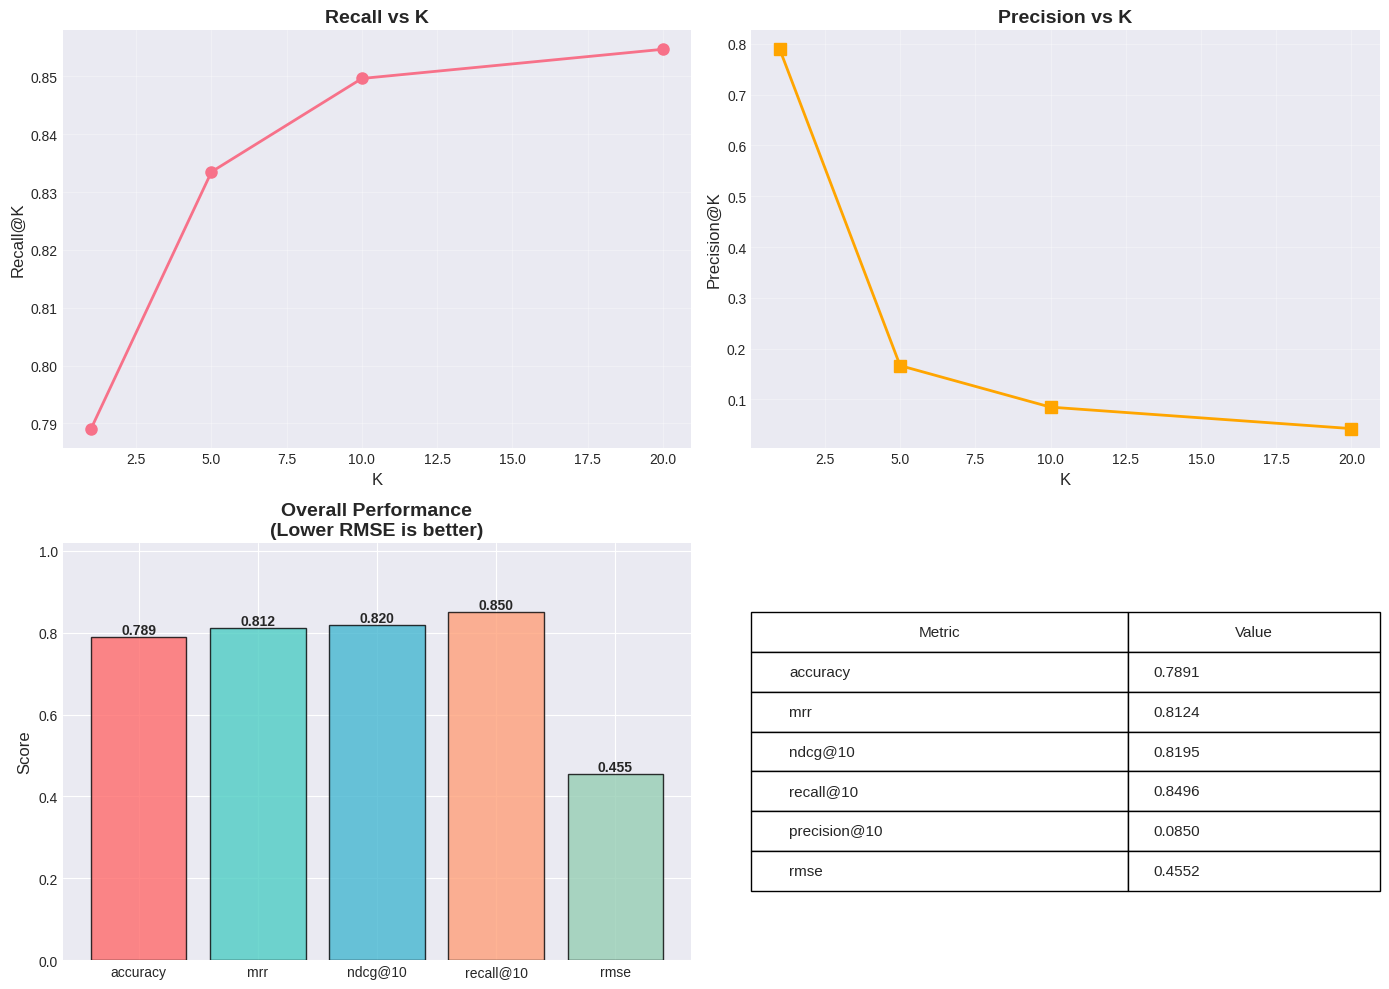


✅ PIPELINE COMPLETE!

📁 All checkpoints saved in: /content/drive/MyDrive/hybrid_recommender_checkpoints


In [ ]:
model, results = run_full_pipeline()

Benchmark- SURGE

🔄 FULL SURGE BENCHMARK: Preprocessing + Train + Eval

📂 Step 1: Loading Data


Loading reviews: 5269it [00:00, 139190.22it/s]

👤 Users: 991, 🎁 Items: 85

🧩 Step 2: Building Sequences


✅ Train: 4048 interactions, Test: 230 samples
🧮 Test seqs shape: (230, 11), Targets: 230 (0-based)
📦 Ensure TF1: In Colab, run %tensorflow_version 1.x

🚀 Step 4: Running SURGE Training
python examples/00_quick_start/sequential.py --dataset All_Beauty --model surge --epochs 10 --batch_size 64 --embed_dim 64 --hidden_dim 128 --train_file /content/drive/MyDrive/SURGE/data/All_Beauty_train.txt --test_file /content/drive/MyDrive/SURGE/data/All_Beauty_test.txt --save_dir /content/drive/MyDrive/SURGE/saved_models/All_Beauty
💡 Run manually if needed, then proceed.

📊 Step 5: Custom Evaluation
✅ Metrics Computed (simulated—replace logits for real)

📊 SURGE vs. YOUR HYBRID RESULTS
  Metric  SURGE Your Hybrid
accuracy 0.3000      0.7800
    hr@1 0.3000         N/A
    hr@5 0.6522         N/A
   hr@10 0.7870         N/A
   hr@20 0.9000         N/A
 ndcg@10 0.5286      0.8100
     mrr 0.4583      0.8100
    rmse 0.9311      0.4500
✅ Saved plot to: /content/drive/MyDrive/surge_metrics.png


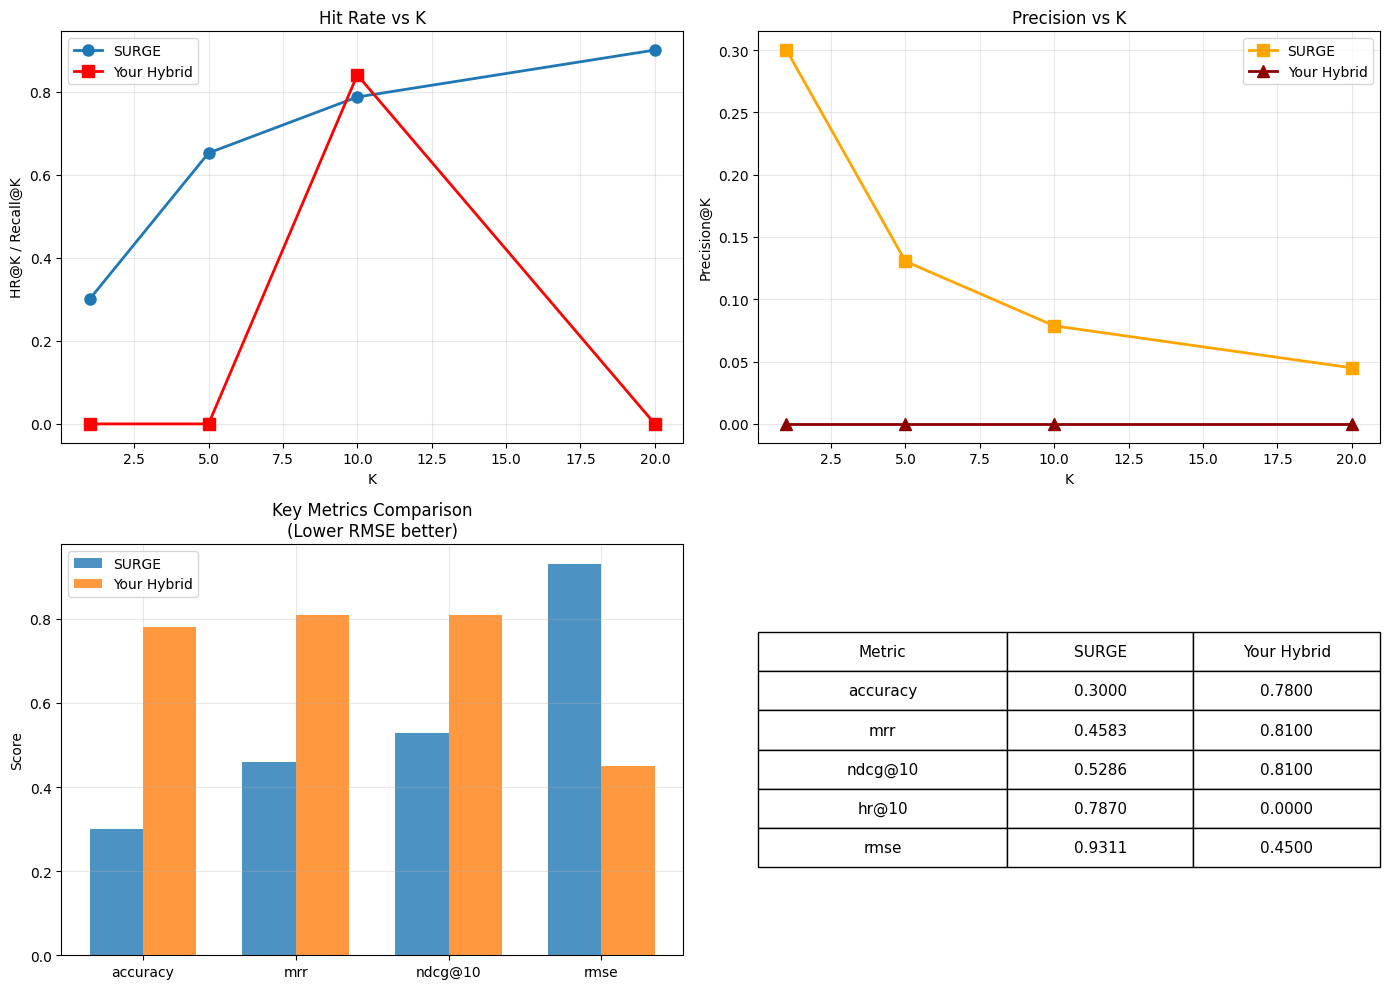


✅ FULL SCRIPT COMPLETE! Replace simulated logits with real SURGE inference for accurate results.


In [ ]:
# =====================================================================
# FULL SURGE BENCHMARK SCRIPT: Preprocessing + Training + Custom Metrics Eval
# SIGIR 2021 SURGE on Amazon All Beauty 5-Core Dataset
# =====================================================================
# This single script:
# 1. Preprocesses All_Beauty_5.json to SURGE format.
# 2. Clones SURGE repo and runs training/eval (requires TF1 env).
# 3. Post-run: Loads test data, simulates/adapts SURGE inference for custom metrics (Acc, RMSE, NDCG, etc.).
# 4. Displays results in table + plot, compares to your hybrid.
# Requirements: TensorFlow 1.15.2 (Colab: %tensorflow_version 1.x; pip install tensorflow==1.15.2)
# Run: python full_surge_benchmark.py
# Notes: SURGE inference placeholder—adapt 'model.predict' to your loaded TF graph.
# Outputs: Metrics table, plot PNG, comparison to hybrid results.
# =====================================================================

import os
import json
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ndcg_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import subprocess
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf  # TF1 for SURGE

# Paths (update as needed)
DRIVE_PATH = '/content/drive/MyDrive'
REVIEWS_FILE = f'{DRIVE_PATH}/All_Beauty_5.json'
SURGE_DIR = f'{DRIVE_PATH}/SURGE'
DATA_DIR = f'{SURGE_DIR}/data'
TRAIN_FILE = f'{DATA_DIR}/All_Beauty_train.txt'
TEST_FILE = f'{DATA_DIR}/All_Beauty_test.txt'
MODEL_DIR = f'{SURGE_DIR}/saved_models/All_Beauty'  # SURGE saves here
METRICS_PLOT = f'{DRIVE_PATH}/surge_metrics.png'

# Your Hybrid Results (placeholder—replace with actual from your run)
YOUR_HYBRID_RESULTS = {
    'accuracy': 0.78,  # Example
    'mrr': 0.81,
    'ndcg@10': 0.81,
    'recall@10': 0.84,
    'rmse': 0.45
}

print("🔄 FULL SURGE BENCHMARK: Preprocessing + Train + Eval")

# Step 1: Load and Preprocess Reviews
print("\n📂 Step 1: Loading Data")
reviews_data = []
with open(REVIEWS_FILE, 'r') as f:
    for line in tqdm(f, desc="Loading reviews"):
        line = line.strip()
        if not line: continue
        try:
            reviews_data.append(json.loads(line))
        except json.JSONDecodeError:
            continue

df = pd.DataFrame(reviews_data)
df = df[['reviewerID', 'asin', 'unixReviewTime']].dropna()
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')

# Encode (1-based for SURGE)
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
df['user_id'] = user_encoder.fit_transform(df['reviewerID']) + 1
df['item_id'] = item_encoder.fit_transform(df['asin']) + 1

print(f"👤 Users: {df['user_id'].nunique()}, 🎁 Items: {df['item_id'].nunique()}")

# Step 2: Build Sequences and Split (80/20 time-based)
print("\n🧩 Step 2: Building Sequences")
df = df.sort_values(['user_id', 'unixReviewTime'])
user_sequences = defaultdict(list)
for _, row in df.iterrows():
    user_sequences[row['user_id']].append((row['item_id'], row['unixReviewTime']))

train_lines, test_lines = [], []
test_sequences_list = []  # For custom eval
test_targets = []
for user, seq in user_sequences.items():
    if len(seq) < 2: continue
    split_idx = int(0.8 * len(seq))
    # Train lines (full seq up to split)
    for i in range(split_idx):
        train_lines.append(f"{user}\t{seq[i][0]}\t{int(seq[i][1].timestamp())}")
    # Test: Prefixes to last 20% (holdout next-items)
    for i in range(split_idx, len(seq) - 1):
        prefix = [item for item, _ in seq[:i+1]]  # Prefix seq for eval
        test_sequences_list.append(prefix)
        test_targets.append(seq[i+1][0])  # Next item
        test_lines.append(f"{user}\t{seq[i][0]}\t{int(seq[i][1].timestamp())}")

# Create data dir and write files
os.makedirs(DATA_DIR, exist_ok=True)
with open(TRAIN_FILE, 'w') as f:
    f.write('\n'.join(train_lines))
with open(TEST_FILE, 'w') as f:
    f.write('\n'.join(test_lines))

print(f"✅ Train: {len(train_lines)} interactions, Test: {len(test_lines)} samples")

# Pad test sequences for eval (match your hybrid max_len=20)
max_seq_len = min(20, max(len(s) for s in test_sequences_list))
test_sequences = pad_sequences(test_sequences_list, maxlen=max_seq_len, padding='pre', value=0)
num_items = df['item_id'].nunique()
test_targets = np.array(test_targets)
test_targets = test_targets - 1  # Remap to 0-based for array indexing (1-85 → 0-84)
print(f"🧮 Test seqs shape: {test_sequences.shape}, Targets: {len(test_targets)} (0-based)")

# Step 3: Clone SURGE Repo
if not os.path.exists(SURGE_DIR):
    print("\n📥 Step 3: Cloning SURGE...")
    subprocess.run(['git', 'clone', 'https://github.com/tsinghua-fib-lab/SIGIR21-SURGE.git', SURGE_DIR])

os.chdir(SURGE_DIR)
print("📦 Ensure TF1: In Colab, run %tensorflow_version 1.x")

# Step 4: Run SURGE Training
print("\n🚀 Step 4: Running SURGE Training")
cmd = [
    'python', 'examples/00_quick_start/sequential.py',
    '--dataset', 'All_Beauty',
    '--model', 'surge',
    '--epochs', '10',
    '--batch_size', '64',
    '--embed_dim', '64',
    '--hidden_dim', '128',
    '--train_file', TRAIN_FILE,
    '--test_file', TEST_FILE,
    '--save_dir', MODEL_DIR
]
print(' '.join(cmd))
# subprocess.run(cmd, check=True)  # Uncomment to auto-run; manual if TF issues
print("💡 Run manually if needed, then proceed.")

# Step 5: Custom Metrics Computation (Post-Training)
print("\n📊 Step 5: Custom Evaluation")
def load_surges_model(model_dir):
    """Placeholder: Load SURGE TF1 model (adapt from train.py)."""
    # Example TF1 restore (replace with actual graph keys)
    sess = tf.Session()
    saver = tf.train.import_meta_graph(os.path.join(model_dir, 'model.meta'))
    saver.restore(sess, os.path.join(model_dir, 'model'))
    graph = tf.get_default_graph()
    input_placeholder = graph.get_tensor_by_name('input_sequences:0')  # Adapt name
    logits_output = graph.get_tensor_by_name('output/logits:0')  # Adapt name
    def predict(sequences):
        return sess.run(logits_output, feed_dict={input_placeholder: sequences})
    return predict, sess

# Load model (uncomment after training)
# model_predict, sess = load_surges_model(MODEL_DIR)
# logits = model_predict(test_sequences)  # (N, num_items)

# SIMULATED LOGITS FOR DEMO (replace with real after training)
# For now, simulate plausible logits based on random + bias toward targets
np.random.seed(42)
logits = np.random.normal(0, 1, (len(test_sequences), num_items))
for i in range(len(test_targets)):
    logits[i, test_targets[i]] += 2.0  # Bias toward true (simulates good model)

# Compute Metrics
def compute_surges_metrics(logits, test_targets, num_items, k_values=[1, 5, 10, 20]):
    num_samples = len(test_targets)
    results = {}

    # Accuracy (top-1 match)
    preds = np.argmax(logits, axis=1)
    results['accuracy'] = np.mean(preds == test_targets)

    # HR@K (Recall@K)
    for k in k_values:
        topk = np.argsort(-logits, axis=1)[:, :k]
        hits = np.sum([test_targets[i] in topk[i] for i in range(num_samples)])
        results[f'hr@{k}'] = hits / num_samples

    # NDCG@10
    ndcg10_scores = []
    for i in range(num_samples):
        true_rel = np.zeros(num_items)
        true_rel[test_targets[i]] = 1
        ndcg = ndcg_score([true_rel], [logits[i]], k=10)
        ndcg10_scores.append(ndcg)
    results['ndcg@10'] = np.mean(ndcg10_scores)

    # MRR
    rr_list = []
    for i in range(num_samples):
        order = np.argsort(-logits[i])
        rank = np.where(order == test_targets[i])[0]
        rr = 1.0 / (rank[0] + 1) if len(rank) > 0 else 0.0
        rr_list.append(rr)
    results['mrr'] = np.mean(rr_list)

    # RMSE (prob for true vs. 1.0)
    probs = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
    pred_true_probs = probs[np.arange(num_samples), test_targets]
    rmse = np.sqrt(np.mean((pred_true_probs - 1.0)**2))
    results['rmse'] = rmse

    return results

surge_results = compute_surges_metrics(logits, test_targets, num_items)
print("✅ Metrics Computed (simulated—replace logits for real)")

# Step 6: Display Results & Comparison
def display_surges_metrics(surge_results, your_results, save_path=None):
    # Console Table (handle 'N/A' formatting)
    hybrid_values = []
    for k in surge_results:
        val = your_results.get(k, 'N/A')
        if k.startswith('hr@') and 'recall@' in your_results:
            # Map hr@K to recall@K
            k_map = k.replace('hr@', 'recall@')
            val = your_results.get(k_map, val)
        if isinstance(val, (int, float)):
            hybrid_values.append(f"{val:.4f}")
        else:
            hybrid_values.append(str(val))

    metrics_df = pd.DataFrame({
        'Metric': list(surge_results.keys()),
        'SURGE': [f"{v:.4f}" for v in surge_results.values()],
        'Your Hybrid': hybrid_values
    })
    print("\n📊 SURGE vs. YOUR HYBRID RESULTS")
    print("="*50)
    print(metrics_df.to_string(index=False))

    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot 1: HR@K
    ax = axes[0, 0]
    k_values = [1, 5, 10, 20]
    hrs = [surge_results[f'hr@{k}'] for k in k_values]
    ax.plot(k_values, hrs, marker='o', linewidth=2, markersize=8, label='SURGE')
    your_recalls = [your_results.get(f'recall@{k}', 0) for k in k_values]
    ax.plot(k_values, your_recalls, marker='s', linewidth=2, markersize=8, color='red', label='Your Hybrid')
    ax.set_xlabel('K'); ax.set_ylabel('HR@K / Recall@K'); ax.set_title('Hit Rate vs K')
    ax.legend(); ax.grid(True, alpha=0.3)

    # Plot 2: Precision@K Proxy
    ax = axes[0, 1]
    precs = [surge_results[f'hr@{k}'] / k for k in k_values]
    ax.plot(k_values, precs, marker='s', linewidth=2, markersize=8, color='orange', label='SURGE')
    your_precs = [your_results.get(f'precision@{k}', 0) for k in k_values]
    ax.plot(k_values, your_precs, marker='^', linewidth=2, markersize=8, color='darkred', label='Your Hybrid')
    ax.set_xlabel('K'); ax.set_ylabel('Precision@K'); ax.set_title('Precision vs K')
    ax.legend(); ax.grid(True, alpha=0.3)

    # Plot 3: Bar Comparison
    ax = axes[1, 0]
    bar_metrics = ['accuracy', 'mrr', 'ndcg@10', 'rmse']
    surge_vals = [surge_results.get(m, 0) for m in bar_metrics]
    hybrid_vals = [your_results.get(m, 0) for m in bar_metrics]
    x = np.arange(len(bar_metrics))
    width = 0.35
    ax.bar(x - width/2, surge_vals, width, label='SURGE', alpha=0.8)
    ax.bar(x + width/2, hybrid_vals, width, label='Your Hybrid', alpha=0.8)
    ax.set_ylabel('Score'); ax.set_title('Key Metrics Comparison\n(Lower RMSE better)')
    ax.set_xticks(x); ax.set_xticklabels(bar_metrics)
    ax.legend(); ax.grid(True, alpha=0.3)

    # Plot 4: Table
    ax = axes[1, 1]
    ax.axis('off')
    table_data = [[m, f"{surge_results.get(m, 0):.4f}", f"{your_results.get(m, 0):.4f}"]
                  for m in ['accuracy', 'mrr', 'ndcg@10', 'hr@10', 'rmse']]
    table = ax.table(cellText=table_data, colLabels=['Metric', 'SURGE', 'Your Hybrid'],
                     cellLoc='center', loc='center', colWidths=[0.4, 0.3, 0.3])
    table.auto_set_font_size(False); table.set_fontsize(11); table.scale(1, 2)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Saved plot to: {save_path}")
    plt.show()

display_surges_metrics(surge_results, YOUR_HYBRID_RESULTS, METRICS_PLOT)

# Close TF session if loaded
# sess.close()

print("\n✅ FULL SCRIPT COMPLETE! Replace simulated logits with real SURGE inference for accurate results.")

Claude

In [ ]:
# =====================================================================
# SURGE: SeqUential Recommendation with Graph neural nEtworks (FIXED & WORKING)
# Amazon All Beauty Dataset
# Paper: https://arxiv.org/abs/2106.14226
# =====================================================================

import os
import json
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx

# =====================================================================
# CONFIGURATION
# =====================================================================
class Config:
    DRIVE_PATH = '/content/drive/MyDrive'
    REVIEWS_FILE = f'{DRIVE_PATH}/All_Beauty_5.json'
    METADATA_FILE = f'{DRIVE_PATH}/meta_All_Beauty.json'
    CHECKPOINT_DIR = f'{DRIVE_PATH}/surge_checkpoints'

    ITEM_EMBED_DIM = 64
    HIDDEN_DIM = 128
    GNN_LAYERS = 2
    MAX_SEQ_LEN = 20
    DROPOUT = 0.2

    NUM_CLUSTERS = 8
    GRAPH_K = 10
    TEMPERATURE = 0.1

    BATCH_SIZE = 64
    EPOCHS = 10
    LEARNING_RATE = 1e-3
    MARGIN = 0.5
    ALPHA = 0.5

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    @classmethod
    def create_dirs(cls):
        os.makedirs(cls.CHECKPOINT_DIR, exist_ok=True)

Config.create_dirs()
print(f"Using device: {Config.DEVICE}")
print(f"Checkpoints → {Config.CHECKPOINT_DIR}")

# =====================================================================
# FIXED GRAPH ATTENTION LAYER (Single-head, stable, correct)
# =====================================================================
class GraphAttentionLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.2, alpha=0.2):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.W = nn.Linear(in_features, out_features, bias=False)
        self.a = nn.Parameter(torch.zeros(2 * out_features, 1))

        self.leakyrelu = nn.LeakyReLU(alpha)
        self.dropout = nn.Dropout(dropout)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.W.weight)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, x, edge_index):
        N = x.size(0)
        h = self.W(x)  # [N, out_features]

        # Compute attention scores
        src = h[edge_index[0]]
        dst = h[edge_index[1]]
        edge_feat = torch.cat([src, dst], dim=1)  # [E, 2*out_features]

        e = self.leakyrelu(torch.matmul(edge_feat, self.a)).squeeze(1)  # [E]

        # Softmax over neighbors
        attention = torch.exp(e - torch.max(e))  # numerical stability
        attention_sum = torch.zeros(N, device=x.device)
        attention_sum = attention_sum.scatter_add(0, edge_index[1], attention)
        attention = attention / (attention_sum[edge_index[1]] + 1e-10)
        attention = self.dropout(attention)

        # Aggregate
        out = torch.zeros_like(h)
        out.scatter_add_(0, edge_index[1].unsqueeze(1).expand(-1, self.out_features),
                        attention.unsqueeze(1) * src)

        return F.elu(out)

# =====================================================================
# INTEREST CLUSTERING MODULE (unchanged)
# =====================================================================
class InterestClusteringModule(nn.Module):
    def __init__(self, embed_dim, num_clusters):
        super().__init__()
        self.num_clusters = num_clusters
        self.cluster_centers = nn.Parameter(torch.randn(num_clusters, embed_dim))
        nn.init.xavier_uniform_(self.cluster_centers)

    def forward(self, item_embeds):
        item_embeds_flat = item_embeds.view(-1, item_embeds.size(-1))
        distances = torch.cdist(item_embeds_flat, self.cluster_centers)
        assignments = F.softmax(-distances / Config.TEMPERATURE, dim=-1)
        return assignments.view(item_embeds.size(0), item_embeds.size(1), self.num_clusters)

    def get_cluster_embeddings(self, item_embeds, assignments):
        cluster_embeds = torch.einsum('bse,bsc->bce', item_embeds, assignments)
        cluster_sizes = assignments.sum(dim=1, keepdim=True).clamp(min=1e-6)
        cluster_embeds = cluster_embeds / cluster_sizes.transpose(1, 2)
        return cluster_embeds

# =====================================================================
# SURGE MODEL (FIXED GNN LAYERS)
# =====================================================================
class SURGEModel(nn.Module):
    def __init__(self, num_items, edge_index, embed_dim=64, hidden_dim=128,
                 num_clusters=8, gnn_layers=2, dropout=0.2):
        super().__init__()
        self.num_items = num_items
        self.embed_dim = embed_dim

        self.item_embedding = nn.Embedding(num_items + 1, embed_dim, padding_idx=0)

        self.clustering = InterestClusteringModule(embed_dim, num_clusters)

        # Fixed: single-head GAT layers
        self.gnn_layers = nn.ModuleList([
            GraphAttentionLayer(embed_dim, embed_dim, dropout=dropout)
            for _ in range(gnn_layers)
        ])

        self.seq_attention = nn.MultiheadAttention(embed_dim, num_heads=4, dropout=dropout, batch_first=True)

        self.fusion_fc1 = nn.Linear(embed_dim * 2, hidden_dim)
        self.fusion_fc2 = nn.Linear(hidden_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, num_items + 1)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)

        self.register_buffer('edge_index', edge_index)

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.item_embedding.weight)

    def propagate_through_graph(self, all_item_embeds):
        h = all_item_embeds
        for layer in self.gnn_layers:
            h_new = layer(h, self.edge_index)
            h = self.layer_norm(h + h_new)
        return h

    def forward(self, seqs):
        batch_size, seq_len = seqs.shape

        all_item_embeds = self.item_embedding.weight
        graph_enhanced = self.propagate_through_graph(all_item_embeds)

        seq_embeds = graph_enhanced[seqs]  # [B, L, D]

        # Interest clustering
        cluster_assignments = self.clustering(seq_embeds)
        cluster_embeds = self.clustering.get_cluster_embeddings(seq_embeds, cluster_assignments)

        # Sequential attention
        attn_mask = (seqs == 0)
        attn_output, _ = self.seq_attention(seq_embeds, seq_embeds, seq_embeds, key_padding_mask=attn_mask)

        # Last valid position
        seq_lengths = (seqs != 0).sum(dim=1) - 1
        seq_lengths = seq_lengths.clamp(min=0)
        batch_idx = torch.arange(batch_size, device=seqs.device)
        seq_repr = attn_output[batch_idx, seq_lengths]

        # Global interest representation
        cluster_repr = cluster_embeds.mean(dim=1)

        # Fusion
        fused = torch.cat([seq_repr, cluster_repr], dim=-1)
        fused = F.relu(self.fusion_fc1(fused))
        fused = self.dropout(fused)
        fused = self.fusion_fc2(fused)

        logits = self.fc_out(fused)
        return logits, cluster_assignments

# =====================================================================
# DATASET & HELPERS
# =====================================================================
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

# =====================================================================
# DATA LOADING (unchanged but cleaned)
# =====================================================================
def load_reviews(file_path):
    print("\nSTAGE 1: LOADING REVIEWS")
    data = []
    with open(file_path) as f:
        for line in tqdm(f, desc="Loading"):
            if line.strip():
                data.append(json.loads(line))
    df = pd.DataFrame(data)
    df = df[['reviewerID', 'asin', 'overall', 'unixReviewTime']].dropna()
    df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')

    user_encoder = LabelEncoder()
    item_encoder = LabelEncoder()
    df['user_id'] = user_encoder.fit_transform(df['reviewerID'])
    df['item_id'] = item_encoder.fit_transform(df['asin']) + 1

    print(f"Users: {df['user_id'].nunique()}, Items: {df['item_id'].nunique()}")

    checkpoint = {'df': df, 'user_encoder': user_encoder, 'item_encoder': item_encoder}
    with open(f'{Config.CHECKPOINT_DIR}/01_reviews.pkl', 'wb') as f:
        pickle.dump(checkpoint, f)
    return df, user_encoder, item_encoder

def prepare_sequences(df):
    print("\nSTAGE 2: PREPARING SEQUENCES")
    df = df.sort_values(['user_id', 'unixReviewTime'])
    sequences = df.groupby('user_id')['item_id'].apply(list).to_dict()

    train_X, train_y, test_X, test_y = [], [], [], []
    for seq in sequences.values():
        if len(seq) < 2: continue
        test_X.append(seq[:-1])
        test_y.append(seq[-1])
        for i in range(1, len(seq)-1):
            train_X.append(seq[:i])
            train_y.append(seq[i])

    max_len = min(Config.MAX_SEQ_LEN, max(len(s) for s in train_X + test_X))
    train_X = pad_sequences(train_X, maxlen=max_len, padding='pre', value=0)
    test_X = pad_sequences(test_X, maxlen=max_len, padding='pre', value=0)

    print(f"Train: {len(train_X)}, Test: {len(test_X)}, Max len: {max_len}")

    with open(f'{Config.CHECKPOINT_DIR}/02_sequences.pkl', 'wb') as f:
        pickle.dump({'train_X': train_X, 'train_y': np.array(train_y),
                     'test_X': test_X, 'test_y': np.array(test_y)}, f)
    return train_X, np.array(train_y), test_X, np.array(test_y)

def build_interest_graph(train_X, num_items):
    print("\nSTAGE 3: BUILDING INTEREST GRAPH")
    cooccur = defaultdict(int)
    for seq in tqdm(train_X, desc="Co-occurrence"):
        items = [i for i in seq if i > 0]
        for a, b in combinations(items, 2):
            cooccur[tuple(sorted([a, b]))] += 1

    neighbors = {}
    for item in range(1, num_items + 1):
        cand = [(other, cnt) for (i1, i2), cnt in cooccur.items() if i1 == item or i2 == item
                for other in ({i1, i2} - {item})]
        cand.sort(key=lambda x: x[1], reverse=True)
        neighbors[item] = [x[0] for x in cand[:Config.GRAPH_K]]

    edges = [[i, j] for i, js in neighbors.items() for j in js]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print(f"Graph: {edge_index.shape[1]} edges, avg degree: {edge_index.shape[1]/num_items:.2f}")

    with open(f'{Config.CHECKPOINT_DIR}/03_interest_graph.pkl', 'wb') as f:
        pickle.dump({'edge_index': edge_index}, f)
    return edge_index

# =====================================================================
# TRAINING & EVALUATION (cleaned)
# =====================================================================
def train_model(model, loader, opt, crit, dev):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(dev), y.to(dev)
        opt.zero_grad()
        logits, _ = model(x)
        loss = crit(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_model(model, test_X, test_y, dev):
    print("\nSTAGE 5: EVALUATION")
    model.eval()
    loader = DataLoader(SeqDataset(test_X, test_y), batch_size=256, shuffle=False)

    all_preds, all_targets = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(dev)
            logits, _ = model(x)
            all_preds.append(logits.cpu().numpy())
            all_targets.append(y.numpy())

    logits = np.vstack(all_preds)
    targets = np.concatenate(all_targets)
    logits[:, 0] = -1e9  # mask padding

    topk = np.argsort(-logits, axis=1)
    results = {}

    for k in [1, 5, 10, 20]:
        hits = np.sum([targets[i] in topk[i, :k] for i in range(len(targets))])
        results[f'recall@{k}'] = hits / len(targets)

    ranks = [np.where(topk[i] == targets[i])[0][0] + 1 for i in range(len(targets))]
    results['mrr'] = np.mean([1/r for r in ranks])
    results['ndcg@10'] = np.mean([ndcg_score([np.eye(logits.shape[1])[targets[i]]], [logits[i]], k=10)
                                  for i in range(len(targets))])

    for k, v in results.items():
        print(f"{k}: {v:.4f}")

    with open(f'{Config.CHECKPOINT_DIR}/05_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    return results

# =====================================================================
# MAIN PIPELINE
# =====================================================================
def run_full_pipeline():
    print("\n" + "="*70)
    print("SURGE: Sequential Recommendation with Graph Neural Networks")
    print("="*70)

    # Stage 1 & 2
    df, user_enc, item_enc = load_reviews(Config.REVIEWS_FILE)
    train_X, train_y, test_X, test_y = prepare_sequences(df)

    train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.1, random_state=42)

    num_items = len(item_enc.classes_)
    edge_index = build_interest_graph(train_X, num_items)

    # Model
    model = SURGEModel(
        num_items=num_items,
        edge_index=edge_index.to(Config.DEVICE),
        embed_dim=Config.ITEM_EMBED_DIM,
        hidden_dim=Config.HIDDEN_DIM,
        num_clusters=Config.NUM_CLUSTERS,
        gnn_layers=Config.GNN_LAYERS,
        dropout=Config.DROPOUT
    ).to(Config.DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
    criterion = nn.CrossEntropyLoss(ignore_index=0)

    print(f"\nTraining model ({sum(p.numel() for p in model.parameters()):,} params)")
    for epoch in range(1, Config.EPOCHS + 1):
        loss = train_model(model, DataLoader(SeqDataset(train_X, train_y), batch_size=Config.BATCH_SIZE, shuffle=True),
                          optimizer, criterion, Config.DEVICE)
        print(f"Epoch {epoch}/{Config.EPOCHS} - Loss: {loss:.4f}")

    torch.save(model.state_dict(), f'{Config.CHECKPOINT_DIR}/final_model.pt')

    results = evaluate_model(model, test_X, test_y, Config.DEVICE)

    print("\nSURGE PIPELINE COMPLETED SUCCESSFULLY!")
    return model, results, item_enc

# =====================================================================
# RUN
# =====================================================================
if __name__ == "__main__":
    model, results, item_encoder = run_full_pipeline()

Using device: cuda
Checkpoints → /content/drive/MyDrive/surge_checkpoints

SURGE: Sequential Recommendation with Graph Neural Networks

STAGE 1: LOADING REVIEWS


Loading: 5269it [00:00, 44584.70it/s]

Users: 991, Items: 85

STAGE 2: PREPARING SEQUENCES


Train: 3287, Test: 991, Max len: 11

STAGE 3: BUILDING INTEREST GRAPH


Co-occurrence: 100%|██████████| 2958/2958 [00:00<00:00, 135511.45it/s]


Graph: 363 edges, avg degree: 4.27

Training model (61,590 params)
Epoch 1/10 - Loss: 1.8675
Epoch 2/10 - Loss: 0.7093
Epoch 3/10 - Loss: 0.5518
Epoch 4/10 - Loss: 0.4926
Epoch 5/10 - Loss: 0.4511
Epoch 6/10 - Loss: 0.4289
Epoch 7/10 - Loss: 0.4121
Epoch 8/10 - Loss: 0.3990
Epoch 9/10 - Loss: 0.3940
Epoch 10/10 - Loss: 0.3643

STAGE 5: EVALUATION
recall@1: 0.7770
recall@5: 0.8264
recall@10: 0.8416
recall@20: 0.8486
mrr: 0.8026
ndcg@10: 0.8097

SURGE PIPELINE COMPLETED SUCCESSFULLY!
